In [1]:
import glob
from collections import defaultdict
from multiprocessing import Pool

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm
from Bio import SeqIO
from scipy.spatial.distance import cdist
from pymutspec.annotation.spectra import get_cossim, collapse_sbs192
from pymutspec.annotation import CodonAnnotation, rev_comp
from pymutspec.constants import possible_sbs192, possible_sbs12, possible_codons
from pymutspec.draw import plot_mutspec192, plot_mutspec12
from pymutspec.annotation import calculate_mutspec

import warnings
warnings.filterwarnings("ignore")

coda = CodonAnnotation(gencode=2)

## Derive species-specific spectra of mtDNA genes

### Calculate and save Expected mut counts for mtDNA genes

(with conservative sites)

In [2]:
# load raw alignments for each gene-species
paths_msa = glob.glob('/home/kpotoh/nemu-pipeline/data/chordata2/output/*/*/msa_nuc.fasta') 
len(paths_msa)

9252

In [3]:
#helper functions for parallel data processing 

def calc_acgt_share(seq: str):
    """get share of sites that are not gaps (-) and Ns"""
    n = len(seq)
    acgt = seq.count("A") + seq.count("C") + seq.count("G") + seq.count("T")
    return acgt / n

In [6]:
# collect synonymous expected mutations counts (that will be used for spectra adjusting/normalization)
data = []
list_of_species = list()

i = 0
for path_fasta in tqdm.tqdm(paths_msa):
    i += 1
    p_elements = path_fasta.split('/')
    
    gene_species = p_elements[8]
    gene, species = gene_species.split('__')
    list_of_species.append(gene_species)

    msa = [str(r.seq) for r in list(SeqIO.parse(path_fasta, 'fasta')) if r.id != 'OUTGRP']

    # filter out partial seqs (< 80%)
    msa_flt = [x for x in msa if calc_acgt_share(x) > 0.8]
    
    # collect descriptive features
    msa_flt_nseqs = len(msa_flt)
    msa_flt_ncols = len(msa_flt[0])
    acgt_share_mean = np.mean([calc_acgt_share(x) for x in msa_flt])


    nseqs = len(msa_flt)
    
    # put all data about one spectrum into dict
    mean_exp = defaultdict(float)
    mean_exp['gene'] = gene
    mean_exp['species'] = species
    mean_exp['msa_nseqs'] = msa_flt_nseqs
    mean_exp['msa_ncols'] = msa_flt_ncols
    mean_exp['acgt_share'] = acgt_share_mean
        
    data.append(mean_exp)


exp_raw_df = pd.DataFrame(data)
exp_raw_df.to_csv('./chordates_dataset/raw_exp_descr.csv', index=False, float_format='%g')

100%|██████████| 9252/9252 [01:37<00:00, 94.42it/s]  


In [7]:
exp_raw_df

,gene,species,msa_nseqs,msa_ncols,acgt_share
0,ND6,Microtus_richardsoni,17,522,1.000000
1,ND6,Macaca_mulatta,39,525,0.999951
2,ND6,Bos_taurus,77,525,0.999629
3,ND6,Spilogale_gracilis,17,525,1.000000
4,ND6,Geothlypis_philadelphia,16,516,1.000000
...,...,...,...,...,...
9247,CO3,Setophaga_tigrina,15,783,1.000000
9248,CO3,Peromyscus_maniculatus,85,771,0.991028
9249,CO3,Chaetodipus_arenarius,44,681,0.996162
9250,CO3,Microtus_richardsoni,17,783,1.000000


### Merge observed (reconstructed by NeMu-pipeline) mutations tables

In [ ]:
# NeMu-pipeline generate many output files in several directories for each input
# So, we also need to aggregate the outputs

paths_observed = glob.glob('../../nemu-pipeline/data/chordata2/output/*/*/tables/observed_mutations.tsv')
cols_useless = ['ProbaFull', 'Gene']
data_obs = []

for p in tqdm.tqdm(paths_observed, 'Species-Gene'):
    gene, species = p.split('/')[7].split('__')
    cur_obs = pd.read_csv(p, sep='\t')
    cur_obs = cur_obs.assign(species=species, gene=gene)\
        .drop(cols_useless, axis=1).rename(columns={'PosInGene': 'Site', 'Label': 'MutType'})
    data_obs.append(cur_obs)

obs_df = pd.concat(data_obs, ignore_index=True)
obs_df.to_csv(f'./chordates_dataset/raw_obs_muts.csv', index=False)

Species-Gene: 100%|██████████| 9232/9232 [00:31<00:00, 292.51it/s]


In [11]:
# all mutations for all processed genes of all species
# Label=0 means NON-SYN mutation
# Label=1 means SYN mutation
# Label=2 means SYN mutation at fourfold site

obs_df

,Mut,MutType,Site,PosInCodon,RefCodon,AltCodon,RefAa,AltAa,ProbaRef,ProbaMut,RefNode,AltNode,species,gene
0,G[A>G]A,2,270,3,GGA,GGG,G,G,0.99933,0.999320,Node1,Node2,Microtus_richardsoni,ND6
1,C[G>A]G,2,420,3,GCG,GCA,A,A,0.99998,0.987490,Node2,Node3,Microtus_richardsoni,ND6
2,G[T>C]A,1,285,3,AGT,AGC,S,S,0.98637,0.976713,Node3,Node4,Microtus_richardsoni,ND6
3,A[G>A]G,1,228,3,GAG,GAA,E,E,0.98737,0.987360,Node3,Node17,Microtus_richardsoni,ND6
4,G[C>T]T,1,40,1,CTA,TTA,L,L,0.99952,0.999510,Node4,Node5,Microtus_richardsoni,ND6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118,C[G>A]C,0,715,1,GCT,ACT,A,T,0.99893,0.998930,Node9,RN_10,Cercopithecus_albogularis,CO3
119,T[C>T]G,1,732,3,TTC,TTT,F,F,0.99818,0.998180,Node9,RN_10,Cercopithecus_albogularis,CO3
120,T[G>A]C,1,132,3,ATG,ATA,M,M,0.99816,0.998160,Node10,RN_4,Cercopithecus_albogularis,CO3
121,C[T>C]C,2,330,3,CCT,CCC,P,P,0.99634,0.996340,Node10,RN_4,Cercopithecus_albogularis,CO3


## Analysis and filtration of exp

In [12]:
# exp_raw_df = pd.read_csv('../data/new_dataset/exp_num_raw.csv')
exp_raw_df

,gene,species,msa_nseqs,msa_ncols,acgt_share
0,ND6,Microtus_richardsoni,17,522,1.000000
1,ND6,Macaca_mulatta,39,525,0.999951
2,ND6,Bos_taurus,77,525,0.999629
3,ND6,Spilogale_gracilis,17,525,1.000000
4,ND6,Geothlypis_philadelphia,16,516,1.000000
...,...,...,...,...,...
9247,CO3,Setophaga_tigrina,15,783,1.000000
9248,CO3,Peromyscus_maniculatus,85,771,0.991028
9249,CO3,Chaetodipus_arenarius,44,681,0.996162
9250,CO3,Microtus_richardsoni,17,783,1.000000


In [13]:
# acgt_share is normal (>0.95), i.e. we have low number of gaps and Ns
exp_raw_df.groupby('gene').acgt_share.describe()

,count,mean,std,min,25%,50%,75%,max
gene,,,,,,,,
A6,487.0,0.998118,0.005428,0.944786,0.998848,0.999944,1.0,1.0
A8,183.0,0.995098,0.008072,0.959566,0.993600,0.999167,1.0,1.0
CO1,1011.0,0.999375,0.001680,0.982821,0.999577,1.000000,1.0,1.0
CO2,237.0,0.998395,0.004503,0.968632,0.999435,1.000000,1.0,1.0
CO3,246.0,0.999013,0.002311,0.985125,0.999402,1.000000,1.0,1.0
Cytb,3218.0,0.998628,0.002823,0.963201,0.998461,0.999836,1.0,1.0
ND1,403.0,0.998360,0.004175,0.959742,0.998986,0.999970,1.0,1.0
ND2,1823.0,0.996567,0.005912,0.950530,0.995346,0.999514,1.0,1.0
ND3,233.0,0.997420,0.006359,0.945336,0.998545,1.000000,1.0,1.0


In [ ]:
# msa_nseqs (number of seqs in alignment) is ok (>=7 in general; >=13 in median)
exp_raw_df.groupby('gene').msa_nseqs.describe()

,count,mean,std,min,25%,50%,75%,max
gene,,,,,,,,
A6,487.0,26.589322,31.845688,9.0,13.0,17.0,29.00,500.0
A8,183.0,19.928962,36.177681,7.0,11.0,13.0,20.00,484.0
CO1,1011.0,22.427300,34.118422,8.0,10.0,14.0,22.00,500.0
CO2,237.0,22.481013,35.491892,9.0,12.0,15.0,22.00,488.0
CO3,246.0,25.504065,39.776185,9.0,12.0,15.0,23.75,499.0
Cytb,3218.0,32.912057,40.536724,9.0,12.0,19.0,36.00,499.0
ND1,403.0,29.074442,38.819834,9.0,12.0,18.0,30.00,490.0
ND2,1823.0,30.968733,39.014642,8.0,12.0,19.0,33.00,467.0
ND3,233.0,22.124464,32.669676,9.0,11.0,14.0,23.00,467.0


In [15]:
# for nice visualization
_gene_order = [
    'Cytb', 'ND2', 'CO1', 'CO3',
    'ND5', 'ND4', 'ND4L', 
    'ND3',  'A6', 'A8', 'CO2',
    'ND1', 'ND6', 
]

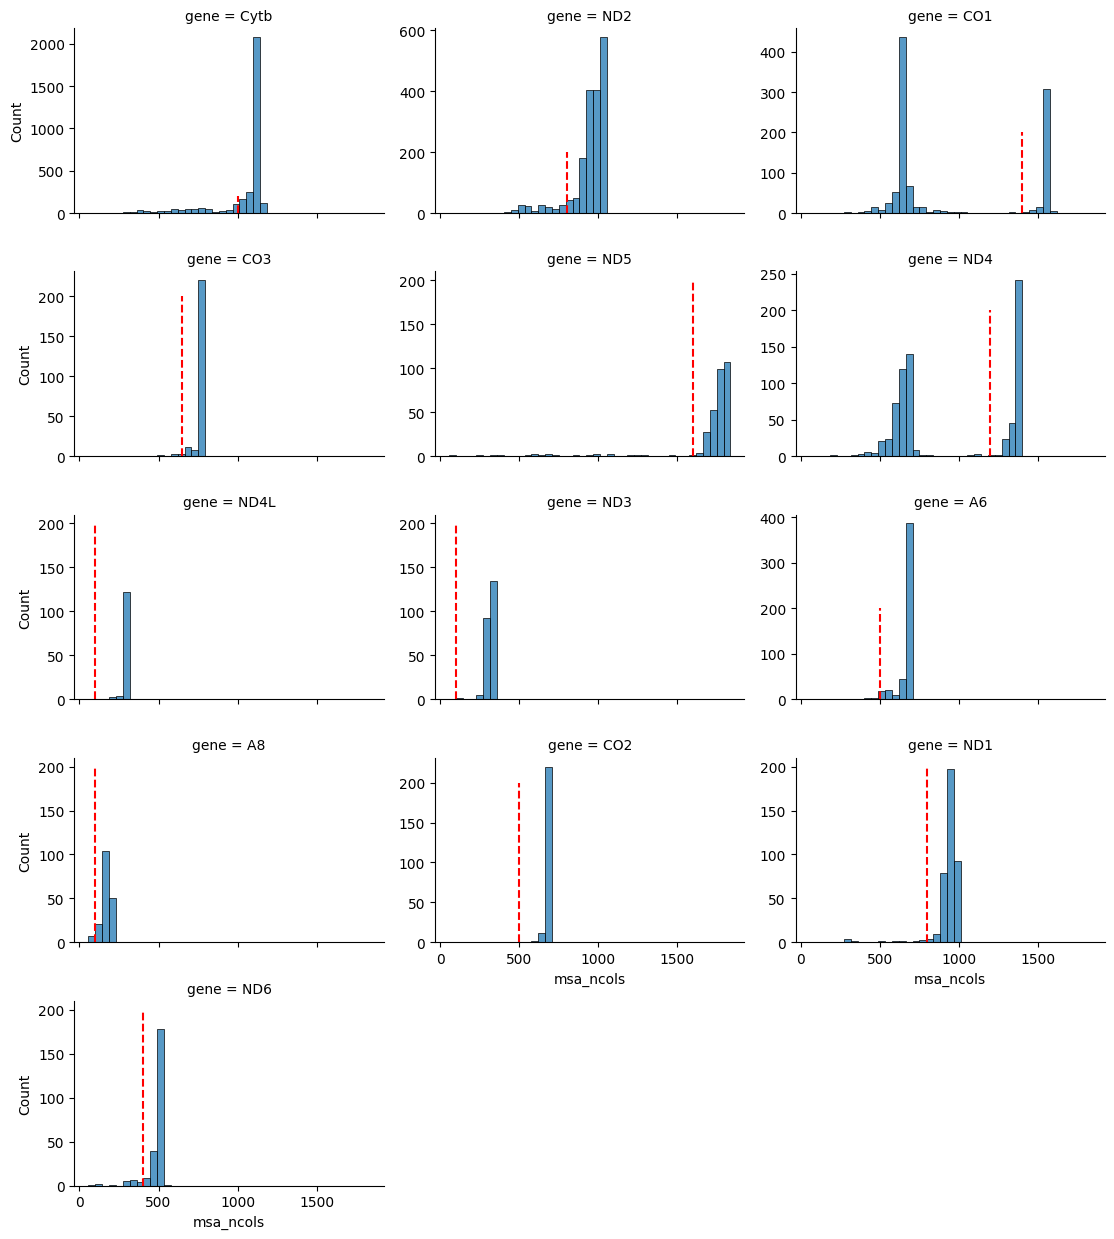

In [25]:
# Distributions of alignments lengths for each gene
# We see that some genes often partially sequences
# We need to filter out them to make our data and analyses homogeneous
g = sns.displot(data=exp_raw_df, x='msa_ncols', col='gene', col_order=_gene_order,
            height=2.5, aspect=1.5, col_wrap=3, kind='hist', facet_kws={'sharey': False})

# msa ncols filtration cutoffs:
# images for supplements
gene_len_cufoffs = dict(
    Cytb=1000,
    ND1=800, ND2=800, ND3=100,
    ND4=1200, ND4L=100, ND5=1600, ND6=400,
    CO1=1400, CO2=500, CO3=650,
    A6=500, A8=100,
)
for _gene, _cut in gene_len_cufoffs.items():
    g.axes_dict[_gene].vlines(_cut, 0, 200, 'red', '--')

g.savefig('./msa_ncols_distributions.pdf')

In [26]:
# table with gene alignments length distributions
exp_raw_df.groupby('gene').msa_ncols.describe()

,count,mean,std,min,25%,50%,75%,max
gene,,,,,,,,
A6,487.0,659.605749,52.683118,255.0,672.00,678.0,681.0,792.0
A8,183.0,165.327869,28.910275,57.0,153.00,165.0,189.0,204.0
CO1,1011.0,953.008902,425.200844,186.0,651.00,657.0,1542.0,1599.0
CO2,237.0,678.734177,24.812368,351.0,681.00,681.0,684.0,732.0
CO3,246.0,771.109756,35.969717,519.0,783.00,783.0,783.0,786.0
Cytb,3218.0,1047.768179,180.784435,234.0,1065.00,1137.0,1140.0,1194.0
ND1,403.0,922.756824,106.201842,261.0,909.00,954.0,966.0,978.0
ND2,1823.0,947.165661,119.419176,282.0,933.00,972.0,1032.0,1053.0
ND3,233.0,319.763948,31.852977,135.0,288.00,339.0,345.0,351.0


### Clean up dataset!

Select species that have nearly full sequence

In [28]:
exp_raw_df_flt = []
for _gene, _cut in gene_len_cufoffs.items():
    _ = exp_raw_df[(exp_raw_df.gene == _gene) & (exp_raw_df.msa_ncols > _cut)]
    exp_raw_df_flt.append(_)
exp_raw_df_flt = pd.concat(exp_raw_df_flt, ignore_index=True)
exp_raw_df_flt

,gene,species,msa_nseqs,msa_ncols,acgt_share
0,Cytb,Cribroheros_alfari,11,1113,0.999837
1,Cytb,Rhodeus_sinensis,9,1140,1.000000
2,Cytb,Praomys_rostratus,47,1140,0.995595
3,Cytb,Niviventer_eha,18,1134,0.998824
4,Cytb,Dremomys_everetti,12,1116,0.995744
...,...,...,...,...,...
7351,A8,Mammuthus_primigenius,27,189,0.973741
7352,A8,Sceloporus_scalaris,17,165,0.999643
7353,A8,Phoca_groenlandica,10,201,0.995025
7354,A8,Crocidura_suaveolens,13,201,1.000000


In [29]:
print('Number of used species for selected genes')
exp_raw_df_flt.gene.value_counts()

Number of used species for selected genes


Cytb    2650
ND2     1661
A6       479
ND1      382
CO1      338
ND4      315
ND5      291
CO3      239
CO2      236
ND3      233
ND6      227
A8       176
ND4L     129
Name: gene, dtype: int64

### add class labels

In [41]:
# load taxinfo table
taxinfo = pd.read_csv('../../nemu-pipeline/data/chordata2/info.csv')
taxinfo['species'] = taxinfo['species'].str.replace(' ', '_')
taxinfo['class'] = taxinfo['taxa'].apply(lambda x: '_'.join(x.split(';')[1].split('_')[:-1]))

# add to info table the class column
df_info = exp_raw_df_flt.merge(taxinfo.drop(['acc', 'taxa'], axis=1), on=['species', 'gene'])

# use only 5 main classes
df_info = df_info[df_info['class'].isin(df_info['class'].value_counts().index[:5])]

# distribution of species in the selected classes
df_info['class'].value_counts()

Mammalia        2676
Actinopteri     1760
Aves            1539
Lepidosauria     779
Amphibia         419
Name: class, dtype: int64

In [42]:
df_info

,gene,species,msa_nseqs,msa_ncols,acgt_share,class
0,Cytb,Cribroheros_alfari,11,1113,0.999837,Actinopteri
1,Cytb,Rhodeus_sinensis,9,1140,1.000000,Actinopteri
2,Cytb,Praomys_rostratus,47,1140,0.995595,Mammalia
3,Cytb,Niviventer_eha,18,1134,0.998824,Mammalia
4,Cytb,Dremomys_everetti,12,1116,0.995744,Mammalia
...,...,...,...,...,...,...
7351,A8,Mammuthus_primigenius,27,189,0.973741,Mammalia
7352,A8,Sceloporus_scalaris,17,165,0.999643,Lepidosauria
7353,A8,Phoca_groenlandica,10,201,0.995025,Mammalia
7354,A8,Crocidura_suaveolens,13,201,1.000000,Mammalia


In [47]:
# save cleaned expected mutations
df_info.to_csv('chordates_dataset/raw_info.csv', index=False, float_format='%g')

## Obs analysis and filtration (all mutations)

In [55]:
obs_df_flt = obs_df.merge(df_info[['gene', 'class', 'species']])
obs_df_flt

,Mut,MutType,Site,PosInCodon,RefCodon,AltCodon,RefAa,AltAa,ProbaRef,ProbaMut,RefNode,AltNode,species,gene,class
0,G[A>G]A,2,270,3,GGA,GGG,G,G,0.99933,0.999320,Node1,Node2,Microtus_richardsoni,ND6,Mammalia
1,C[G>A]G,2,420,3,GCG,GCA,A,A,0.99998,0.987490,Node2,Node3,Microtus_richardsoni,ND6,Mammalia
2,G[T>C]A,1,285,3,AGT,AGC,S,S,0.98637,0.976713,Node3,Node4,Microtus_richardsoni,ND6,Mammalia
3,A[G>A]G,1,228,3,GAG,GAA,E,E,0.98737,0.987360,Node3,Node17,Microtus_richardsoni,ND6,Mammalia
4,G[C>T]T,1,40,1,CTA,TTA,L,L,0.99952,0.999510,Node4,Node5,Microtus_richardsoni,ND6,Mammalia
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
979856,C[G>A]C,0,715,1,GCT,ACT,A,T,0.99893,0.998930,Node9,RN_10,Cercopithecus_albogularis,CO3,Mammalia
979857,T[C>T]G,1,732,3,TTC,TTT,F,F,0.99818,0.998180,Node9,RN_10,Cercopithecus_albogularis,CO3,Mammalia
979858,T[G>A]C,1,132,3,ATG,ATA,M,M,0.99816,0.998160,Node10,RN_4,Cercopithecus_albogularis,CO3,Mammalia
979859,C[T>C]C,2,330,3,CCT,CCC,P,P,0.99634,0.996340,Node10,RN_4,Cercopithecus_albogularis,CO3,Mammalia


In [58]:
# calculate the number of species that have mutational spectrum in each class and gene
obs_df_flt.groupby(['gene', 'class']).species.nunique().unstack()\
    .sort_values('Mammalia', ascending=False).fillna(0).astype(int)

class,Actinopteri,Amphibia,Aves,Lepidosauria,Mammalia
gene,,,,,
Cytb,900,95,256,257,1081
ND2,227,148,708,334,193
ND4,57,11,56,15,169
CO1,79,18,50,10,167
ND1,75,54,44,54,150
ND5,53,18,52,9,150
CO2,31,8,40,7,145
CO3,34,12,44,7,137
A6,165,14,120,47,121


### Filter out outlier tree edges
(long branches)

In [83]:
# calculate number of mutations (estimate based on reconstructed probability)
# for each branch. We see outliers (max column)
edge_nobs = obs_df_flt.groupby(['gene', 'species', 'AltNode']).ProbaMut.sum().rename('edge_nobs')
edge_nobs_df = edge_nobs.reset_index()
edge_nobs_df.groupby('gene').quantile([0.5, 0.9]).round(2).unstack()

edge_nobs      
           0.5   0.9
gene                
A6         1.0  4.95
A8         1.0  2.99
CO1        1.0  6.00
CO2        1.0  4.00
CO3        1.0  4.00
Cytb       1.0  6.98
ND1        1.0  6.96
ND2        1.0  8.73
ND3        1.0  4.00
ND4        1.0  6.61
ND4L       1.0  3.88
ND5        1.0  6.49
ND6        1.0  3.74

In [84]:
# funcs for outliers filtrtation 
def get_iqr_bounds(series: pd.Series):
    q1 = series.quantile(0.25)
    q3 = series.quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    return lower_bound, upper_bound


def filter_outliers(data, column=None, max_val=None):
    if isinstance(column, str) and isinstance(data, pd.DataFrame):
        series = data[column]
    elif isinstance(data, pd.Series):
        series = data
    else:
        raise Exception('incorrect input')

    _, upper_bound = get_iqr_bounds(series)
    filtered_data = data[(series <= upper_bound)]
    if max_val:
        filtered_data = filtered_data[(filtered_data[column] <= max_val)]
    return filtered_data

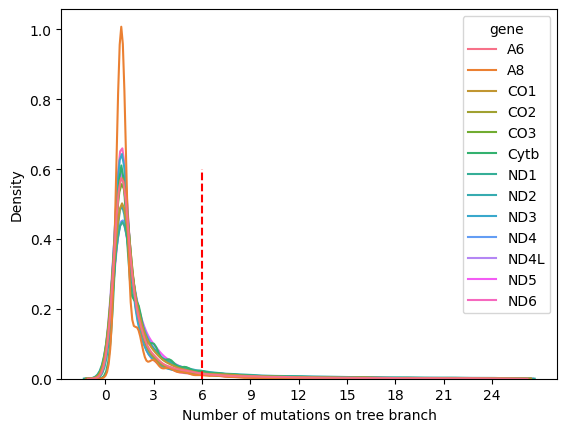

In [85]:
sns.kdeplot(data=edge_nobs_df[edge_nobs_df.edge_nobs<25], 
            x='edge_nobs', hue='gene', common_norm=False)
plt.vlines(6, 0, 0.6, 'r', '--')
plt.xticks(range(0, 27, 3))
plt.xlabel('Number of mutations on tree branch')
# plt.savefig('./figures/tree_branch_mut_cnt.png')
plt.show()

In [86]:
get_iqr_bounds(edge_nobs_df.edge_nobs)

(-1.9708815, 5.9514425)

In [93]:
edge_nobs_df_flt = filter_outliers(edge_nobs_df, 'edge_nobs')
edge_nobs_df_flt.groupby('gene').describe().round(2)

edge_nobs                                        
         count  mean   std   min  25%  50%   75%   max
gene                                                  
A6     11803.0  1.53  1.00  0.30  1.0  1.0  2.00  5.95
A8      2890.0  1.36  0.88  0.32  1.0  1.0  1.00  5.92
CO1     9335.0  1.60  1.04  0.32  1.0  1.0  2.00  5.94
CO2     4857.0  1.45  0.93  0.33  1.0  1.0  1.94  5.95
CO3     5538.0  1.46  0.94  0.30  1.0  1.0  1.98  5.94
Cytb   90132.0  1.72  1.12  0.30  1.0  1.0  2.00  5.95
ND1    10787.0  1.63  1.08  0.31  1.0  1.0  2.00  5.95
ND2    48682.0  1.71  1.14  0.30  1.0  1.0  2.00  5.95
ND3     4605.0  1.44  0.97  0.31  1.0  1.0  1.32  5.94
ND4     9043.0  1.66  1.08  0.31  1.0  1.0  2.00  5.95
ND4L    2483.0  1.43  0.95  0.30  1.0  1.0  1.00  5.85
ND5     9894.0  1.72  1.11  0.30  1.0  1.0  2.00  5.95
ND6     5313.0  1.40  0.87  0.31  1.0  1.0  1.07  5.95

In [94]:
edge_nobs_df_flt

,gene,species,AltNode,edge_nobs
0,A6,Acanthurus_nigricans,Node10,1.00000
1,A6,Acanthurus_nigricans,Node13,1.00000
2,A6,Acanthurus_nigricans,Node2,0.98451
3,A6,Acanthurus_nigricans,Node20,0.99697
4,A6,Acanthurus_nigricans,Node21,1.00000
...,...,...,...,...
243412,ND6,Zonotrichia_albicollis,RN_27,1.00000
243413,ND6,Zonotrichia_albicollis,RN_3,1.00000
243414,ND6,Zonotrichia_albicollis,RN_4,1.00000
243415,ND6,Zonotrichia_albicollis,RN_6,2.00000


In [95]:
edge_nobs[edge_nobs >= 6].sum(), edge_nobs[edge_nobs < 6].sum()

(449479.746244, 367421.216817)

In [96]:
obs_df_flt.shape, obs_df_flt['ProbaMut'].sum().round(2)

((979861, 15), 816900.96)

In [97]:
obs_df_flt_edge_flt = obs_df_flt.merge(edge_nobs_df_flt, on=['gene', 'species', 'AltNode'])
obs_df_flt_edge_flt.shape, obs_df_flt_edge_flt['ProbaMut'].sum().round(2)

((378429, 16), 357984.95)

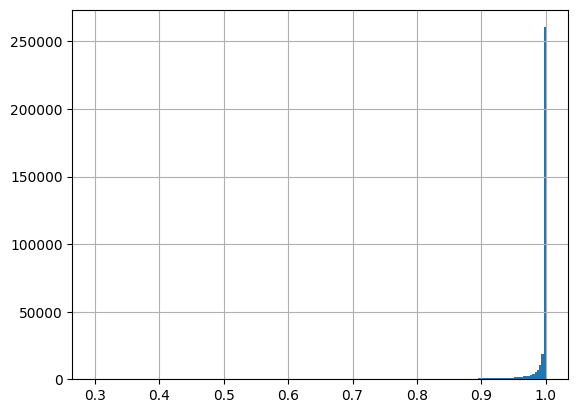

In [98]:
obs_df_flt_edge_flt.ProbaRef.hist(bins=200);

### Filter out gene-species with low number of mutations (nobs>20)

In [103]:
NOBS_CUTOFF = 10  # required at least such number of mutations for each species
nobs = obs_df_flt_edge_flt.groupby(['gene', 'species']).ProbaMut.sum().rename('nobs')
nobs_flt = nobs[nobs >= NOBS_CUTOFF]
nobs_flt_df = nobs_flt.reset_index()
print(nobs.shape, nobs_flt.shape)
nobs_flt.sum(level=0).round(2)

(7166,) (6775,)


gene
A6       17844.72
A8        3658.06
CO1      14823.14
CO2       6919.63
CO3       7917.77
Cytb    154562.85
ND1      17431.35
ND2      82717.28
ND3       6466.93
ND4      14925.51
ND4L      3432.32
ND5      16915.70
ND6       7334.48
Name: nobs, dtype: float64

In [104]:
#before filtration
nobs.reset_index().groupby('gene').nobs.describe().round(2)

,count,mean,std,min,25%,50%,75%,max
gene,,,,,,,,
A6,467.0,38.55,41.83,4.00,17.00,25.95,43.75,500.66
A8,169.0,23.32,30.71,2.00,10.96,15.92,27.31,368.48
CO1,324.0,46.11,65.84,2.88,19.07,29.42,47.79,773.97
CO2,231.0,30.47,35.64,4.00,14.99,22.62,33.61,427.95
CO3,234.0,34.58,42.61,4.00,15.00,23.13,37.93,468.51
Cytb,2589.0,60.01,74.89,2.00,20.71,35.54,66.42,772.65
ND1,377.0,46.65,55.23,3.00,19.46,29.92,50.49,523.60
ND2,1610.0,51.78,72.00,2.00,19.66,30.96,55.77,938.72
ND3,228.0,29.10,31.27,4.00,14.00,21.47,34.48,386.71


In [105]:
#after filtration
nobs_flt_df.groupby('gene').nobs.describe().round(2)

,count,mean,std,min,25%,50%,75%,max
gene,,,,,,,,
A6,448.0,39.83,42.23,10.99,17.99,27.54,44.68,500.66
A8,128.0,28.58,33.63,10.95,14.93,22.01,34.06,368.48
CO1,308.0,48.13,66.92,10.29,19.95,30.21,48.97,773.97
CO2,217.0,31.89,36.31,10.61,15.80,23.44,34.56,427.95
CO3,212.0,37.35,43.85,11.00,17.79,24.98,39.89,468.51
Cytb,2484.0,62.22,75.66,10.12,22.01,36.93,69.50,772.65
ND1,358.0,48.69,55.94,10.62,21.20,31.04,53.07,523.60
ND2,1525.0,54.24,73.20,10.60,21.13,32.40,58.63,938.72
ND3,207.0,31.24,32.05,10.59,15.94,23.73,35.78,386.71


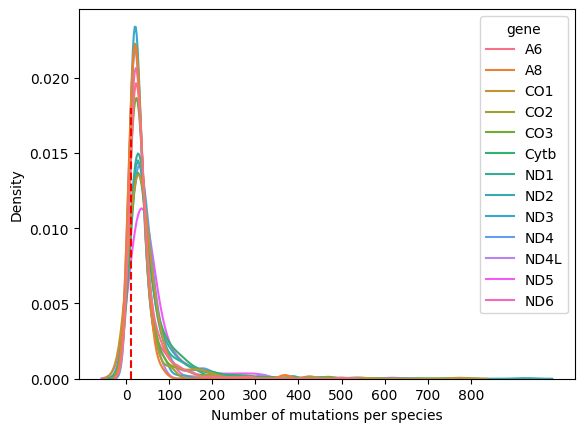

In [107]:
sns.kdeplot(data=nobs_flt_df, x='nobs', hue='gene', common_norm=False)
plt.vlines(10, 0, 0.018, 'r', '--')
plt.xticks(range(0, 801, 100))
plt.xlabel('Number of mutations per species')
# plt.savefig('./figures/mut_cnt_per_species.png')
plt.show()

In [113]:
obs_df_flt_edge_flt.shape

(378429, 16)

In [114]:
obs_df_flt_edge_flt_nobs_flt = obs_df_flt_edge_flt.merge(
        nobs_flt_df.rename(columns={'nobs': 'species_nobs'}), 
        on=['gene', 'species'],
    )
obs_df_flt_edge_flt_nobs_flt.shape

(375267, 17)

In [115]:
obs_df_flt_edge_flt_nobs_flt.groupby(['gene', 'class']).species.nunique().unstack()

class,Actinopteri,Amphibia,Aves,Lepidosauria,Mammalia
gene,,,,,
A6,160,14,112,45,117
A8,40,4,13,21,50
CO1,73,17,49,9,160
CO2,28,8,36,7,138
CO3,32,12,34,7,127
Cytb,854,93,237,242,1058
ND1,74,51,38,54,141
ND2,215,142,664,319,185
ND3,23,22,69,4,89


In [116]:
obs_df_flt_edge_flt_nobs_flt.groupby(['gene', 'class']).ProbaMut.sum().round().unstack()

class,Actinopteri,Amphibia,Aves,Lepidosauria,Mammalia
gene,,,,,
A6,6357.0,655.0,3578.0,2049.0,5206.0
A8,923.0,91.0,311.0,611.0,1723.0
CO1,3801.0,1033.0,1602.0,358.0,8030.0
CO2,762.0,182.0,762.0,190.0,5023.0
CO3,1025.0,315.0,799.0,201.0,5578.0
Cytb,48537.0,7590.0,8921.0,17404.0,72110.0
ND1,3603.0,2761.0,1184.0,3313.0,6571.0
ND2,9578.0,8524.0,27105.0,27521.0,9989.0
ND3,509.0,672.0,1946.0,114.0,3225.0


## Obs filtration (non-syn mutations)

In [155]:
obs_df_ns = obs_df_flt_edge_flt_nobs_flt[obs_df_flt_edge_flt_nobs_flt.MutType == 0]

species_ns_cnt = obs_df_ns.groupby(['gene', 'species']).ProbaMut.sum()
species_ns_cnt = species_ns_cnt[species_ns_cnt > 5]
species_ns_cnt

gene  species                 
A6    Acanthurus_triostegus       11.464210
      Adelomyia_melanogenys       31.799091
      Agkistrodon_contortrix      17.248693
      Agkistrodon_piscivorus       6.984290
      Alethe_diademata             6.999990
                                    ...    
ND6   Trochalopteron_elliotii      9.999540
      Tyto_alba                    6.788070
      Urocyon_cinereoargenteus     5.999990
      Ursus_arctos                20.903561
      Vireo_olivaceus              5.998770
Name: ProbaMut, Length: 3904, dtype: float64

In [156]:
obs_df_ns_flt = obs_df_ns.merge(species_ns_cnt.index.to_frame(index=False))
obs_df_ns_flt

,Mut,MutType,Site,PosInCodon,RefCodon,AltCodon,RefAa,AltAa,ProbaRef,ProbaMut,RefNode,AltNode,species,gene,class,edge_nobs,species_nobs
0,A[A>G]T,0,112,1,ATT,GTT,I,V,0.958489,0.849141,Node5,Node6,Macaca_mulatta,ND6,Mammalia,1.701972,60.872819
1,T[G>A]T,0,127,1,GTT,ATT,V,I,0.974793,0.970650,Node6,Node12,Macaca_mulatta,ND6,Mammalia,4.317346,60.872819
2,G[A>G]T,0,301,1,ATA,GTA,M,V,0.999990,0.999990,Node24,RN_6,Macaca_mulatta,ND6,Mammalia,0.999990,60.872819
3,T[G>A]T,0,109,1,GTA,ATA,V,M,0.999990,0.999990,Node22,RN_32,Macaca_mulatta,ND6,Mammalia,0.999990,60.872819
4,A[A>G]T,0,97,1,ATT,GTT,I,V,1.000000,1.000000,Node25,RN_5,Macaca_mulatta,ND6,Mammalia,1.000000,60.872819
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71036,G[T>C]T,0,320,2,GTT,GCT,V,A,0.997300,0.996791,Node7,Node15,Microtus_richardsoni,CO3,Mammalia,2.990872,37.853841
71037,A[G>A]C,0,470,2,AGC,AAC,S,N,0.976132,0.976132,Node8,Node14,Microtus_richardsoni,CO3,Mammalia,5.215612,37.853841
71038,A[C>T]T,0,139,1,CTT,TTT,L,F,0.980432,0.980432,Node9,RN_10,Microtus_richardsoni,CO3,Mammalia,5.856894,37.853841
71039,A[A>G]T,0,574,1,ATC,GTC,I,V,0.960485,0.960485,Node9,RN_10,Microtus_richardsoni,CO3,Mammalia,5.856894,37.853841


In [160]:
obs_df_ns_flt.to_csv('chordates_dataset/obs_muts.csv', index=False, float_format='%g')

df_info_flt = df_info.merge(obs_df_ns_flt[['gene', 'species']].drop_duplicates())
df_info_flt.to_csv('./chordates_dataset/info.csv', index=False, float_format='%g')

In [163]:
df_info_flt.groupby(['gene', 'class']).species.count().unstack()

class,Actinopteri,Amphibia,Aves,Lepidosauria,Mammalia
gene,,,,,
A6,86.0,9.0,41.0,38.0,70.0
A8,24.0,3.0,8.0,21.0,41.0
CO1,16.0,5.0,3.0,3.0,37.0
CO2,3.0,3.0,9.0,3.0,43.0
CO3,5.0,3.0,4.0,5.0,50.0
Cytb,442.0,72.0,102.0,176.0,726.0
ND1,35.0,33.0,8.0,37.0,61.0
ND2,153.0,113.0,412.0,284.0,132.0
ND3,6.0,12.0,20.0,3.0,43.0


## Analyse 

In [169]:
amino_acid_codes = {
    "A": "Ala",
    "R": "Arg",
    "N": "Asn",
    "D": "Asp",
    "C": "Cys",
    "Q": "Gln",
    "E": "Glu",
    "G": "Gly",
    "H": "His",
    "I": "Ile",
    "L": "Leu",
    "K": "Lys",
    "M": "Met",
    "F": "Phe",
    "P": "Pro",
    "S": "Ser",
    "T": "Thr",
    "W": "Trp",
    "Y": "Tyr",
    "V": "Val",
    "*": "*",
}
obs_df_ns_flt['RefAa'] = obs_df_ns_flt['RefAa'].map(amino_acid_codes)
obs_df_ns_flt['AltAa'] = obs_df_ns_flt['AltAa'].map(amino_acid_codes)

In [ ]:
- split to genes and maybe classes

In [170]:
obs_df_ns_flt.groupby(['RefAa', 'AltAa']).ProbaMut.sum().unstack().fillna(0).round(1)

AltAa,Ala,Arg,Asn,Asp,Cys,Gln,Glu,Gly,His,Ile,Leu,Lys,Met,Phe,Pro,Ser,Thr,Trp,Tyr,Val
RefAa,,,,,,,,,,,,,,,,,,,,
Ala,0.0,0.0,0.0,93.6,0.0,0.0,76.5,460.7,0.0,0.0,0.0,0.0,0.0,0.0,244.7,348.9,7086.0,0.0,0.0,1078.0
Arg,0.0,0.0,0.0,0.0,29.4,236.9,0.0,80.9,90.3,0.0,23.0,0.0,0.0,0.0,83.5,12.6,0.0,60.6,0.0,0.0
Asn,0.0,0.0,0.0,573.1,0.0,0.0,0.0,0.0,156.9,115.9,0.0,330.2,0.0,0.0,0.0,1632.4,214.5,0.0,155.4,0.0
Asp,35.7,0.0,1153.6,0.0,0.0,0.0,163.0,156.0,46.9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,49.0,16.6
Cys,0.0,29.9,0.0,0.0,0.0,0.0,0.0,24.0,0.0,0.0,0.0,0.0,0.0,10.1,0.0,58.3,0.0,55.5,111.3,0.0
Gln,0.0,203.8,0.0,0.0,0.0,0.0,61.1,0.0,170.7,0.0,60.3,99.5,0.0,0.0,125.9,0.0,0.0,0.0,0.0,0.0
Glu,18.4,0.0,0.0,103.7,0.0,111.9,0.0,151.6,0.0,0.0,0.0,478.7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,22.7
Gly,174.0,157.9,0.0,166.8,41.9,0.0,177.3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,716.2,0.0,49.6,0.0,62.6
His,0.0,201.8,114.6,42.9,0.0,194.5,0.0,0.0,0.0,0.0,73.1,0.0,0.0,0.0,147.2,0.0,0.0,0.0,432.6,0.0
